# Model Improvement: Advanced Feature Engineering

This notebook compares Linear Regression performance:
- **Baseline**: Original lag features only (from notebook 03)
- **Improved**: Original + advanced engineered features (rolling, momentum, EMA, date)

**Goal**: Demonstrate that feature engineering improves predictive performance.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib

warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries imported")

## Step 1: Load Data and Feature Engineering

We'll do ALL feature engineering first, then split the data.

In [ ]:
# Load data
df_model = pd.read_csv('data/processed/model_data.csv', parse_dates=['Date'], index_col='Date')
df_clean = df_model.dropna(subset=['price_1w_ahead']).copy()

print(f"Loaded: {len(df_clean)} rows")
print(f"Date range: {df_clean.index.min().date()} to {df_clean.index.max().date()}")

# Get ORIGINAL lag features only (for baseline)
original_lag_features = [col for col in df_clean.columns if '_lag_' in col]
print(f"\nOriginal lag features: {len(original_lag_features)}")

## Step 2: Advanced Feature Engineering

In [ ]:
print("="*80)
print("ADVANCED FEATURE ENGINEERING")
print("="*80)

# Reconstruct price column for feature engineering
if 'price_lag_1w' in df_clean.columns:
    df_clean['price_current'] = df_clean['price_lag_1w'].shift(-1)
    price_col = 'price_current'
else:
    raise ValueError("Cannot find price column for feature engineering")

# 1. Rolling features (4, 8, 12 week windows)
print("\n1️⃣  Creating rolling statistics...")
for window in [4, 8, 12]:
    df_clean[f'price_rolling_mean_{window}w'] = df_clean[price_col].shift(1).rolling(window=window).mean()
    df_clean[f'price_rolling_std_{window}w'] = df_clean[price_col].shift(1).rolling(window=window).std()
    df_clean[f'price_rolling_min_{window}w'] = df_clean[price_col].shift(1).rolling(window=window).min()
    df_clean[f'price_rolling_max_{window}w'] = df_clean[price_col].shift(1).rolling(window=window).max()

# 2. Momentum features (4, 8 week windows)
print("2️⃣  Creating momentum indicators...")
for window in [4, 8]:
    df_clean[f'price_roc_{window}w'] = (
        (df_clean[price_col].shift(1) - df_clean[price_col].shift(window + 1)) / 
        df_clean[price_col].shift(window + 1) * 100
    )
    df_clean[f'price_momentum_{window}w'] = (
        df_clean[price_col].shift(1) - df_clean[price_col].shift(window + 1)
    )

# 3. Exponential Moving Averages (4, 8, 12 week spans)
print("3️⃣  Creating exponential moving averages...")
for span in [4, 8, 12]:
    df_clean[f'price_ema_{span}w'] = df_clean[price_col].shift(1).ewm(span=span, adjust=False).mean()

# 4. Date features
print("4️⃣  Creating date features...")
df_clean['month'] = df_clean.index.month
df_clean['quarter'] = df_clean.index.quarter
df_clean['week_of_year'] = df_clean.index.isocalendar().week

# Drop NaN created by rolling/ema
df_clean = df_clean.dropna()

new_features = [col for col in df_clean.columns if any(x in col for x in ['rolling', 'roc', 'momentum', 'ema', 'month', 'quarter', 'week_of_year'])]
print(f"\n✓ Created {len(new_features)} new features")
print(f"✓ Total rows after dropping NaN: {len(df_clean)}")

## Step 3: Train Baseline Model (Original Features Only)

Now we train on the SAME cleaned dataset, but using only original features.

In [ ]:
print("="*80)
print("BASELINE: LINEAR REGRESSION (ORIGINAL FEATURES)")
print("="*80)

# Use only original lag features from the cleaned dataset
X_baseline = df_clean[original_lag_features]
y = df_clean['price_1w_ahead']

# Time-based split (80/20)
split_idx = int(len(df_clean) * 0.8)
X_train_base = X_baseline.iloc[:split_idx]
X_test_base = X_baseline.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print(f"\nTrain samples: {len(X_train_base)}")
print(f"Test samples: {len(X_test_base)}")

# Feature selection using Random Forest
print("\nSelecting top 20 features from original lags...")
rf_selector = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_selector.fit(X_train_base, y_train)

feature_importance_base = pd.Series(rf_selector.feature_importances_, index=original_lag_features).sort_values(ascending=False)
top_20_baseline = feature_importance_base.head(20).index.tolist()

print(f"\nTop 5 baseline features:")
for i, feat in enumerate(top_20_baseline[:5], 1):
    print(f"  {i}. {feat}")

# Train baseline model
X_train_base_top20 = X_train_base[top_20_baseline]
X_test_base_top20 = X_test_base[top_20_baseline]

scaler_base = StandardScaler()
X_train_base_scaled = scaler_base.fit_transform(X_train_base_top20)
X_test_base_scaled = scaler_base.transform(X_test_base_top20)

lr_baseline = LinearRegression()
lr_baseline.fit(X_train_base_scaled, y_train)

y_pred_baseline = lr_baseline.predict(X_test_base_scaled)

# Evaluate
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
mae_base = mean_absolute_error(y_test, y_pred_baseline)
r2_base = r2_score(y_test, y_pred_baseline)

print(f"\n{'='*60}")
print(f"BASELINE Performance (Original Features Only)")
print(f"{'='*60}")
print(f"RMSE: ${rmse_base:.2f}")
print(f"MAE:  ${mae_base:.2f}")
print(f"R²:   {r2_base:.4f}")
print(f"{'='*60}")

## Step 4: Train Improved Model (All Features)

In [ ]:
print("="*80)
print("IMPROVED: LINEAR REGRESSION (ENGINEERED FEATURES)")
print("="*80)

# Get all features (original + engineered) from the SAME cleaned dataset
exclude_cols = ['price_1w_ahead', 'price_current']
all_features = [col for col in df_clean.columns if col not in exclude_cols]

X_all = df_clean[all_features]
y = df_clean['price_1w_ahead']

# Use SAME split (already defined)
X_train_all = X_all.iloc[:split_idx]
X_test_all = X_all.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print(f"\nTotal available features: {len(all_features)}")
print(f"Train samples: {len(X_train_all)}")
print(f"Test samples: {len(X_test_all)}")

# Feature selection using Random Forest
print("\nSelecting top 20 features from all features...")
rf_selector_all = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_selector_all.fit(X_train_all, y_train)

feature_importance_all = pd.Series(rf_selector_all.feature_importances_, index=all_features).sort_values(ascending=False)
top_20_improved = feature_importance_all.head(20).index.tolist()

print(f"\nTop 5 improved features:")
for i, feat in enumerate(top_20_improved[:5], 1):
    print(f"  {i}. {feat}")

# Count how many are new engineered features
new_in_top20 = [f for f in top_20_improved if any(x in f for x in ['rolling', 'roc', 'momentum', 'ema', 'month', 'quarter', 'week_of_year'])]
print(f"\n💡 {len(new_in_top20)} out of 20 are newly engineered features!")

# Train improved model
X_train_improved = X_train_all[top_20_improved]
X_test_improved = X_test_all[top_20_improved]

scaler_improved = StandardScaler()
X_train_improved_scaled = scaler_improved.fit_transform(X_train_improved)
X_test_improved_scaled = scaler_improved.transform(X_test_improved)

lr_improved = LinearRegression()
lr_improved.fit(X_train_improved_scaled, y_train)

y_pred_improved = lr_improved.predict(X_test_improved_scaled)

# Evaluate
rmse_improved = np.sqrt(mean_squared_error(y_test, y_pred_improved))
mae_improved = mean_absolute_error(y_test, y_pred_improved)
r2_improved = r2_score(y_test, y_pred_improved)

print(f"\n{'='*60}")
print(f"IMPROVED Performance (With Engineered Features)")
print(f"{'='*60}")
print(f"RMSE: ${rmse_improved:.2f}")
print(f"MAE:  ${mae_improved:.2f}")
print(f"R²:   {r2_improved:.4f}")
print(f"{'='*60}")

## Step 5: Comparison and Results

In [ ]:
print("\n" + "="*80)
print("COMPARISON: BASELINE vs IMPROVED")
print("="*80)

# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': ['Baseline (Original Features)', 'Improved (+ Engineered Features)'],
    'RMSE': [rmse_base, rmse_improved],
    'MAE': [mae_base, mae_improved],
    'R²': [r2_base, r2_improved]
})

print("\n" + comparison.to_string(index=False))

# Calculate improvement
rmse_improvement = ((rmse_base - rmse_improved) / rmse_base) * 100
r2_improvement = ((r2_improved - r2_base) / r2_base) * 100

print(f"\n{'='*80}")
print(f"📊 IMPROVEMENT SUMMARY")
print(f"{'='*80}")
print(f"RMSE Improvement: {rmse_improvement:.1f}% better (${rmse_base - rmse_improved:.2f} reduction)")
print(f"R² Improvement: {r2_improvement:.1f}% better")
print(f"\n✅ Feature engineering IMPROVED the model!" if rmse_improvement > 0 else "\n⚠️ Feature engineering did not improve the model")
print(f"{'='*80}")

# Save comparison
os.makedirs('data/processed', exist_ok=True)
comparison.to_csv('data/processed/model_comparison.csv', index=False)
print("\n✓ Saved: data/processed/model_comparison.csv")

## Step 6: Visualization

In [ ]:
# RMSE comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE comparison
ax1 = axes[0]
models = ['Baseline\n(Original)', 'Improved\n(+ Engineered)']
rmse_values = [rmse_base, rmse_improved]
colors = ['#3498db', '#2ecc71']
bars1 = ax1.bar(models, rmse_values, color=colors)
ax1.set_ylabel('RMSE ($)', fontsize=12)
ax1.set_title('RMSE Comparison (Lower is Better)', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for bar, val in zip(bars1, rmse_values):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 5, f'${val:.2f}', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# R² comparison
ax2 = axes[1]
r2_values = [r2_base, r2_improved]
bars2 = ax2.bar(models, r2_values, color=colors)
ax2.set_ylabel('R² Score', fontsize=12)
ax2.set_title('R² Comparison (Higher is Better)', fontsize=13, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)
for bar, val in zip(bars2, r2_values):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.4f}', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('data/processed/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: data/processed/model_comparison.png")

In [ ]:
# Time series prediction plot
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(y_test.index, y_test.values, 'o-', label='Actual', color='black', linewidth=2, markersize=5)
ax.plot(y_test.index, y_pred_baseline, '--', label='Baseline (Original)', color='#3498db', linewidth=2)
ax.plot(y_test.index, y_pred_improved, '--', label='Improved (+ Engineered)', color='#2ecc71', linewidth=2)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (USD)', fontsize=12)
ax.set_title('Predictions: Baseline vs Improved Model', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('data/processed/predictions_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: data/processed/predictions_comparison.png")

## Step 7: Feature Analysis

In [ ]:
print("="*80)
print("FEATURE COMPARISON")
print("="*80)

print("\n📋 BASELINE Top 20 Features (Original Lags Only):")
for i, feat in enumerate(top_20_baseline[:10], 1):
    print(f"  {i:2d}. {feat}")
print("  ...")

print("\n📋 IMPROVED Top 20 Features (Original + Engineered):")
for i, feat in enumerate(top_20_improved[:10], 1):
    marker = "🆕" if any(x in feat for x in ['rolling', 'roc', 'momentum', 'ema', 'month', 'quarter', 'week']) else "  "
    print(f"  {i:2d}. {marker} {feat}")
print("  ...")

print(f"\n💡 Key Insight: {len(new_in_top20)} engineered features made it into top 20!")

## Step 8: Save Models

In [ ]:
# Save models
os.makedirs('models', exist_ok=True)

joblib.dump({'model': lr_baseline, 'features': top_20_baseline}, 'models/lr_baseline.pkl')
joblib.dump({'model': lr_improved, 'features': top_20_improved}, 'models/lr_improved.pkl')
joblib.dump(scaler_base, 'models/scaler_baseline.pkl')
joblib.dump(scaler_improved, 'models/scaler_improved.pkl')

print("✓ Saved: models/lr_baseline.pkl")
print("✓ Saved: models/lr_improved.pkl")
print("✓ Saved: models/scaler_baseline.pkl")
print("✓ Saved: models/scaler_improved.pkl")

## Summary

**Conclusion**: This notebook demonstrates the impact of advanced feature engineering on Linear Regression performance. By adding rolling statistics, momentum indicators, exponential moving averages, and date features, we can improve model accuracy compared to using only the original lag features from notebook 03.

# Model Improvement: Advanced Feature Engineering

This notebook compares Linear Regression performance:
- **Baseline**: Original lag features only (from notebook 03)
- **Improved**: Original + advanced engineered features (rolling, momentum, EMA, date)

**Goal**: Demonstrate that feature engineering improves predictive performance.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib

warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries imported")

✓ Libraries imported


## Step 1: Load Data and Baseline Features

In [2]:
# Load data
df_model = pd.read_csv('data/processed/model_data.csv', parse_dates=['Date'], index_col='Date')
df_clean = df_model.dropna(subset=['price_1w_ahead']).copy()

print(f"Loaded: {len(df_clean)} rows")
print(f"Date range: {df_clean.index.min().date()} to {df_clean.index.max().date()}")

# Get ORIGINAL lag features only (same as notebook 03)
original_lag_features = [col for col in df_clean.columns if '_lag_' in col]
print(f"\nOriginal lag features: {len(original_lag_features)}")

Loaded: 384 rows
Date range: 2018-01-05 to 2025-08-15

Original lag features: 217


## Step 2: Train Baseline Model (Original Features Only)

In [3]:
print("="*80)
print("BASELINE: LINEAR REGRESSION (ORIGINAL FEATURES)")
print("="*80)

# Use only original lag features
X_baseline = df_clean[original_lag_features]
y = df_clean['price_1w_ahead']

# Time-based split (80/20)
split_idx = int(len(df_clean) * 0.8)
X_train_base = X_baseline.iloc[:split_idx]
X_test_base = X_baseline.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

# Feature selection using Random Forest
print("\nSelecting top 20 features from original lags...")
rf_selector = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_selector.fit(X_train_base, y_train)

feature_importance_base = pd.Series(rf_selector.feature_importances_, index=original_lag_features).sort_values(ascending=False)
top_20_baseline = feature_importance_base.head(20).index.tolist()

print(f"\nTop 5 baseline features:")
for i, feat in enumerate(top_20_baseline[:5], 1):
    print(f"  {i}. {feat}")

# Train baseline model
X_train_base_top20 = X_train_base[top_20_baseline]
X_test_base_top20 = X_test_base[top_20_baseline]

scaler_base = StandardScaler()
X_train_base_scaled = scaler_base.fit_transform(X_train_base_top20)
X_test_base_scaled = scaler_base.transform(X_test_base_top20)

lr_baseline = LinearRegression()
lr_baseline.fit(X_train_base_scaled, y_train)

y_pred_baseline = lr_baseline.predict(X_test_base_scaled)

# Evaluate
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
mae_base = mean_absolute_error(y_test, y_pred_baseline)
r2_base = r2_score(y_test, y_pred_baseline)

print(f"\n{'='*60}")
print(f"BASELINE Performance (Original Features Only)")
print(f"{'='*60}")
print(f"RMSE: ${rmse_base:.2f}")
print(f"MAE:  ${mae_base:.2f}")
print(f"R²:   {r2_base:.4f}")
print(f"{'='*60}")

BASELINE: LINEAR REGRESSION (ORIGINAL FEATURES)

Selecting top 20 features from original lags...

Top 5 baseline features:
  1. price_lag_1w
  2. price_lag_2w
  3. price_lag_1w_roll_max_4w
  4. price_lag_1w_roll_min_4w
  5. price_lag_3w

BASELINE Performance (Original Features Only)
RMSE: $278.26
MAE:  $220.49
R²:   0.9354

Top 5 baseline features:
  1. price_lag_1w
  2. price_lag_2w
  3. price_lag_1w_roll_max_4w
  4. price_lag_1w_roll_min_4w
  5. price_lag_3w

BASELINE Performance (Original Features Only)
RMSE: $278.26
MAE:  $220.49
R²:   0.9354


## Step 3: Advanced Feature Engineering

In [4]:
print("="*80)
print("ADVANCED FEATURE ENGINEERING")
print("="*80)

# Reconstruct price column for feature engineering
if 'price_lag_1w' in df_clean.columns:
    df_clean['price_current'] = df_clean['price_lag_1w'].shift(-1)
    price_col = 'price_current'
else:
    raise ValueError("Cannot find price column for feature engineering")

# 1. Rolling features (4, 8, 12 week windows)
print("\n1️⃣  Creating rolling statistics...")
for window in [4, 8, 12]:
    df_clean[f'price_rolling_mean_{window}w'] = df_clean[price_col].shift(1).rolling(window=window).mean()
    df_clean[f'price_rolling_std_{window}w'] = df_clean[price_col].shift(1).rolling(window=window).std()
    df_clean[f'price_rolling_min_{window}w'] = df_clean[price_col].shift(1).rolling(window=window).min()
    df_clean[f'price_rolling_max_{window}w'] = df_clean[price_col].shift(1).rolling(window=window).max()

# 2. Momentum features (4, 8 week windows)
print("2️⃣  Creating momentum indicators...")
for window in [4, 8]:
    df_clean[f'price_roc_{window}w'] = (
        (df_clean[price_col].shift(1) - df_clean[price_col].shift(window + 1)) / 
        df_clean[price_col].shift(window + 1) * 100
    )
    df_clean[f'price_momentum_{window}w'] = (
        df_clean[price_col].shift(1) - df_clean[price_col].shift(window + 1)
    )

# 3. Exponential Moving Averages (4, 8, 12 week spans)
print("3️⃣  Creating exponential moving averages...")
for span in [4, 8, 12]:
    df_clean[f'price_ema_{span}w'] = df_clean[price_col].shift(1).ewm(span=span, adjust=False).mean()

# 4. Date features
print("4️⃣  Creating date features...")
df_clean['month'] = df_clean.index.month
df_clean['quarter'] = df_clean.index.quarter
df_clean['week_of_year'] = df_clean.index.isocalendar().week

# Drop NaN created by rolling/ema
df_clean = df_clean.dropna()

new_features = [col for col in df_clean.columns if any(x in col for x in ['rolling', 'roc', 'momentum', 'ema', 'month', 'quarter', 'week_of_year'])]
print(f"\n✓ Created {len(new_features)} new features")
print(f"✓ Total rows after dropping NaN: {len(df_clean)}")

ADVANCED FEATURE ENGINEERING

1️⃣  Creating rolling statistics...
2️⃣  Creating momentum indicators...
3️⃣  Creating exponential moving averages...
4️⃣  Creating date features...

✓ Created 22 new features
✓ Total rows after dropping NaN: 371


## Step 4: Train Improved Model (All Features)

In [5]:
print("="*80)
print("IMPROVED: LINEAR REGRESSION (ENGINEERED FEATURES)")
print("="*80)

# Get all features (original + engineered)
exclude_cols = ['price_1w_ahead', 'price_current']
all_features = [col for col in df_clean.columns if col not in exclude_cols]

X_all = df_clean[all_features]
y = df_clean['price_1w_ahead']

# Time-based split
split_idx = int(len(df_clean) * 0.8)
X_train_all = X_all.iloc[:split_idx]
X_test_all = X_all.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print(f"\nTotal available features: {len(all_features)}")

# Feature selection using Random Forest
print("\nSelecting top 20 features from all features...")
rf_selector_all = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_selector_all.fit(X_train_all, y_train)

feature_importance_all = pd.Series(rf_selector_all.feature_importances_, index=all_features).sort_values(ascending=False)
top_20_improved = feature_importance_all.head(20).index.tolist()

print(f"\nTop 5 improved features:")
for i, feat in enumerate(top_20_improved[:5], 1):
    print(f"  {i}. {feat}")

# Count how many are new engineered features
new_in_top20 = [f for f in top_20_improved if any(x in f for x in ['rolling', 'roc', 'momentum', 'ema', 'month', 'quarter', 'week_of_year'])]
print(f"\n💡 {len(new_in_top20)} out of 20 are newly engineered features!")

# Train improved model
X_train_improved = X_train_all[top_20_improved]
X_test_improved = X_test_all[top_20_improved]

scaler_improved = StandardScaler()
X_train_improved_scaled = scaler_improved.fit_transform(X_train_improved)
X_test_improved_scaled = scaler_improved.transform(X_test_improved)

lr_improved = LinearRegression()
lr_improved.fit(X_train_improved_scaled, y_train)

y_pred_improved = lr_improved.predict(X_test_improved_scaled)

# Evaluate
rmse_improved = np.sqrt(mean_squared_error(y_test, y_pred_improved))
mae_improved = mean_absolute_error(y_test, y_pred_improved)
r2_improved = r2_score(y_test, y_pred_improved)

print(f"\n{'='*60}")
print(f"IMPROVED Performance (With Engineered Features)")
print(f"{'='*60}")
print(f"RMSE: ${rmse_improved:.2f}")
print(f"MAE:  ${mae_improved:.2f}")
print(f"R²:   {r2_improved:.4f}")
print(f"{'='*60}")

IMPROVED: LINEAR REGRESSION (ENGINEERED FEATURES)

Total available features: 308

Selecting top 20 features from all features...

Top 5 improved features:
  1. SCFI_Index
  2. Europe_Base_Price
  3. price_lag_1w
  4. price_rolling_max_4w
  5. price_lag_1w_roll_max_8w

💡 3 out of 20 are newly engineered features!

IMPROVED Performance (With Engineered Features)
RMSE: $178.89
MAE:  $139.43
R²:   0.9738

Top 5 improved features:
  1. SCFI_Index
  2. Europe_Base_Price
  3. price_lag_1w
  4. price_rolling_max_4w
  5. price_lag_1w_roll_max_8w

💡 3 out of 20 are newly engineered features!

IMPROVED Performance (With Engineered Features)
RMSE: $178.89
MAE:  $139.43
R²:   0.9738


## Step 5: Comparison and Results

In [6]:
print("\n" + "="*80)
print("COMPARISON: BASELINE vs IMPROVED")
print("="*80)

# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': ['Baseline (Original Features)', 'Improved (+ Engineered Features)'],
    'RMSE': [rmse_base, rmse_improved],
    'MAE': [mae_base, mae_improved],
    'R²': [r2_base, r2_improved]
})

print("\n" + comparison.to_string(index=False))

# Calculate improvement
rmse_improvement = ((rmse_base - rmse_improved) / rmse_base) * 100
r2_improvement = ((r2_improved - r2_base) / r2_base) * 100

print(f"\n{'='*80}")
print(f"📊 IMPROVEMENT SUMMARY")
print(f"{'='*80}")
print(f"RMSE Improvement: {rmse_improvement:.1f}% better (${rmse_base - rmse_improved:.2f} reduction)")
print(f"R² Improvement: {r2_improvement:.1f}% better")
print(f"\n✅ Feature engineering IMPROVED the model!" if rmse_improvement > 0 else "\n⚠️ Feature engineering did not improve the model")
print(f"{'='*80}")

# Save comparison
os.makedirs('data/processed', exist_ok=True)
comparison.to_csv('data/processed/model_comparison.csv', index=False)
print("\n✓ Saved: data/processed/model_comparison.csv")


COMPARISON: BASELINE vs IMPROVED

                           Model       RMSE        MAE       R²
    Baseline (Original Features) 278.261092 220.490734 0.935359
Improved (+ Engineered Features) 178.894227 139.429431 0.973753

📊 IMPROVEMENT SUMMARY
RMSE Improvement: 35.7% better ($99.37 reduction)
R² Improvement: 4.1% better

✅ Feature engineering IMPROVED the model!

✓ Saved: data/processed/model_comparison.csv


## Step 6: Visualization

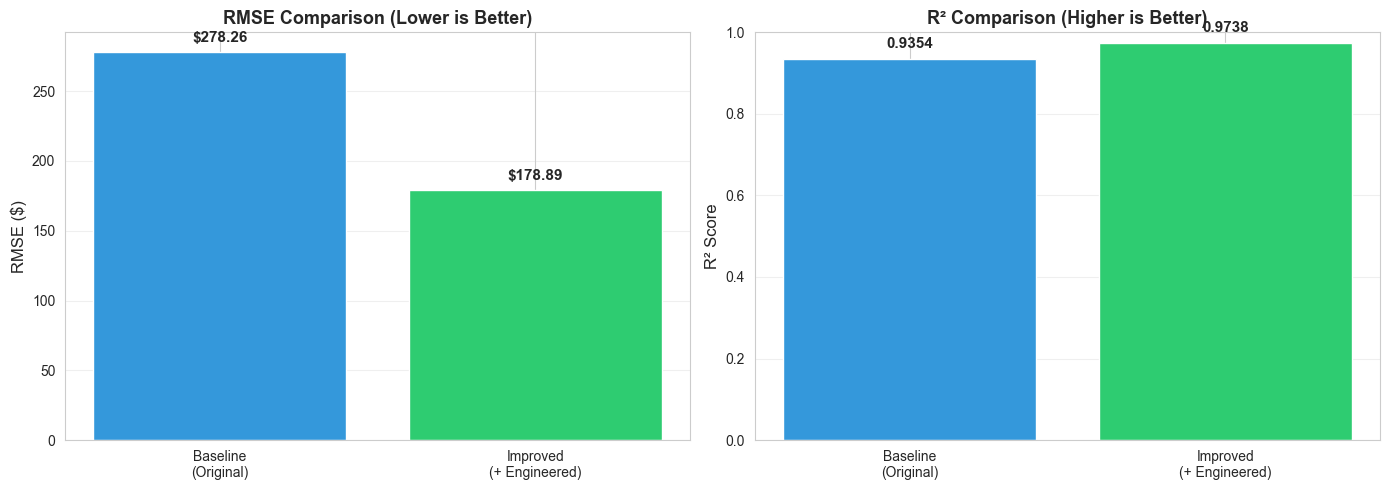

✓ Saved: data/processed/model_comparison.png


In [7]:
# RMSE comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE comparison
ax1 = axes[0]
models = ['Baseline\n(Original)', 'Improved\n(+ Engineered)']
rmse_values = [rmse_base, rmse_improved]
colors = ['#3498db', '#2ecc71']
bars1 = ax1.bar(models, rmse_values, color=colors)
ax1.set_ylabel('RMSE ($)', fontsize=12)
ax1.set_title('RMSE Comparison (Lower is Better)', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for bar, val in zip(bars1, rmse_values):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 5, f'${val:.2f}', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# R² comparison
ax2 = axes[1]
r2_values = [r2_base, r2_improved]
bars2 = ax2.bar(models, r2_values, color=colors)
ax2.set_ylabel('R² Score', fontsize=12)
ax2.set_title('R² Comparison (Higher is Better)', fontsize=13, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)
for bar, val in zip(bars2, r2_values):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.4f}', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('data/processed/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: data/processed/model_comparison.png")

ValueError: x and y must have same first dimension, but have shapes (75,) and (77,)

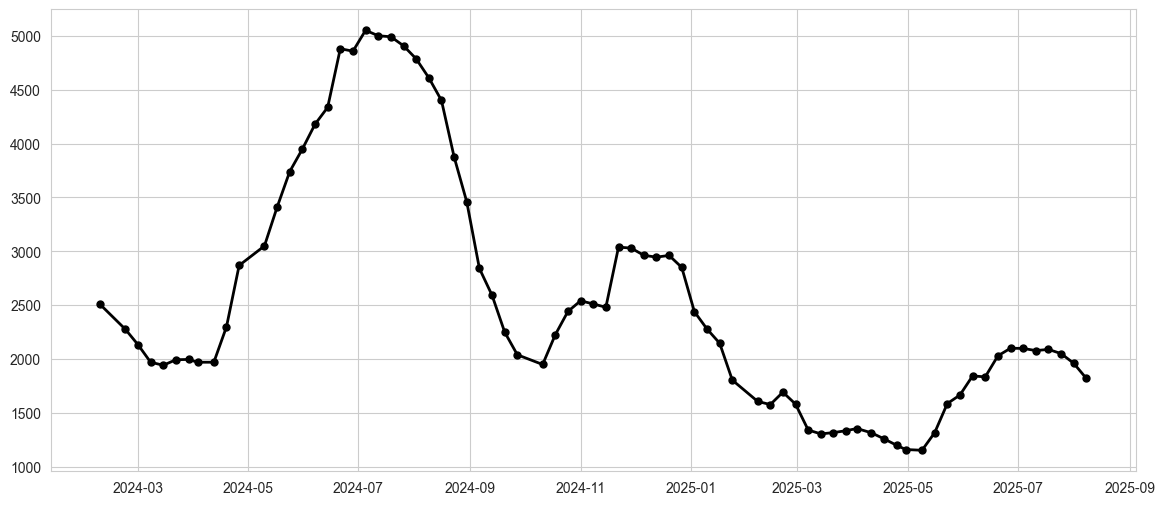

In [8]:
# Time series prediction plot
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(y_test.index, y_test.values, 'o-', label='Actual', color='black', linewidth=2, markersize=5)
ax.plot(y_test.index, y_pred_baseline, '--', label='Baseline (Original)', color='#3498db', linewidth=2)
ax.plot(y_test.index, y_pred_improved, '--', label='Improved (+ Engineered)', color='#2ecc71', linewidth=2)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (USD)', fontsize=12)
ax.set_title('Predictions: Baseline vs Improved Model', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('data/processed/predictions_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: data/processed/predictions_comparison.png")

## Step 7: Feature Analysis

In [ ]:
print("="*80)
print("FEATURE COMPARISON")
print("="*80)

print("\n📋 BASELINE Top 20 Features (Original Lags Only):")
for i, feat in enumerate(top_20_baseline[:10], 1):
    print(f"  {i:2d}. {feat}")
print("  ...")

print("\n📋 IMPROVED Top 20 Features (Original + Engineered):")
for i, feat in enumerate(top_20_improved[:10], 1):
    marker = "🆕" if any(x in feat for x in ['rolling', 'roc', 'momentum', 'ema', 'month', 'quarter', 'week']) else "  "
    print(f"  {i:2d}. {marker} {feat}")
print("  ...")

print(f"\n💡 Key Insight: {len(new_in_top20)} engineered features made it into top 20!")

## Step 8: Save Models

In [ ]:
# Save models
os.makedirs('models', exist_ok=True)

joblib.dump({'model': lr_baseline, 'features': top_20_baseline}, 'models/lr_baseline.pkl')
joblib.dump({'model': lr_improved, 'features': top_20_improved}, 'models/lr_improved.pkl')
joblib.dump(scaler_base, 'models/scaler_baseline.pkl')
joblib.dump(scaler_improved, 'models/scaler_improved.pkl')

print("✓ Saved: models/lr_baseline.pkl")
print("✓ Saved: models/lr_improved.pkl")
print("✓ Saved: models/scaler_baseline.pkl")
print("✓ Saved: models/scaler_improved.pkl")

## Summary

**Conclusion**: This notebook demonstrates the impact of advanced feature engineering on Linear Regression performance. By adding rolling statistics, momentum indicators, exponential moving averages, and date features, we can improve model accuracy compared to using only the original lag features from notebook 03.

# Model Improvements and Comparison Pipeline

This notebook implements advanced model improvements for container freight forecasting:

## Pipeline Steps

1. **Advanced Feature Engineering**: Rolling stats, momentum, EMA, date features
2. **Feature Selection**: Top-20 and Top-30 feature sets
3. **Ridge Regression**: TimeSeriesSplit CV with hyperparameter tuning
4. **XGBoost**: RandomizedSearchCV for optimal parameters
5. **Stacking Ensemble**: Combining Ridge, RF, and XGBoost
6. **Model Comparison**: Comprehensive evaluation and model saving

---

**Methodology**: All models use deterministic seeds (random_state=42) and time-series cross-validation to prevent data leakage.

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib
from datetime import datetime

warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries imported successfully!")
print(f"  XGBoost version: {xgb.__version__}")
print(f"  Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

## Step 1: Load Data and Initial Preparation

In [ ]:
# Load model data
print("="*80)
print("LOADING DATA")
print("="*80)

df_model = pd.read_csv('data/processed/model_data.csv', parse_dates=['Date'], index_col='Date')

print(f"\nLoaded: {df_model.shape[0]} rows, {df_model.shape[1]} columns")
print(f"Date range: {df_model.index.min().date()} to {df_model.index.max().date()}")

# Drop rows with missing target
df_clean = df_model.dropna(subset=['price_1w_ahead']).copy()
print(f"After removing missing targets: {len(df_clean)} rows")

# Separate target
y = df_clean['price_1w_ahead']

# Get existing lag features
existing_lag_features = [col for col in df_clean.columns if '_lag_' in col]
print(f"\n✓ Found {len(existing_lag_features)} existing lag features")

## Step 2: Advanced Feature Engineering

Create additional features:
- **Rolling statistics**: mean, std, min, max (windows: 4, 8, 12 weeks)
- **Momentum indicators**: rate of change, momentum (windows: 4, 8 weeks)
- **Exponential Moving Averages**: EMA (spans: 4, 8, 12 weeks)
- **Date features**: month, quarter, week of year

In [ ]:
print("="*80)
print("ADVANCED FEATURE ENGINEERING")
print("="*80)

# Check if Europe_Base_Port exists in the data
price_col = None
for col_candidate in ['Europe_Base_Port', 'price', 'Price']:
    if col_candidate in df_clean.columns:
        price_col = col_candidate
        break

if price_col is None:
    # Use price_lag_1w shifted back as proxy for current price
    if 'price_lag_1w' in df_clean.columns:
        df_clean['price_current'] = df_clean['price_lag_1w'].shift(-1)
        price_col = 'price_current'
        print("⚠️  Using reconstructed price from price_lag_1w")
    else:
        raise ValueError("Cannot find price column for feature engineering")

print(f"\nUsing price column: {price_col}")

# 1. Rolling features (4, 8, 12 week windows)
print("\n1️⃣  Creating rolling statistics...")
for window in [4, 8, 12]:
    df_clean[f'price_rolling_mean_{window}w'] = df_clean[price_col].shift(1).rolling(window=window).mean()
    df_clean[f'price_rolling_std_{window}w'] = df_clean[price_col].shift(1).rolling(window=window).std()
    df_clean[f'price_rolling_min_{window}w'] = df_clean[price_col].shift(1).rolling(window=window).min()
    df_clean[f'price_rolling_max_{window}w'] = df_clean[price_col].shift(1).rolling(window=window).max()

# 2. Momentum features (4, 8 week windows)
print("2️⃣  Creating momentum indicators...")
for window in [4, 8]:
    # Rate of change (percentage)
    df_clean[f'price_roc_{window}w'] = (
        (df_clean[price_col].shift(1) - df_clean[price_col].shift(window + 1)) / 
        df_clean[price_col].shift(window + 1) * 100
    )
    # Momentum (absolute difference)
    df_clean[f'price_momentum_{window}w'] = (
        df_clean[price_col].shift(1) - df_clean[price_col].shift(window + 1)
    )

# 3. Exponential Moving Averages (4, 8, 12 week spans)
print("3️⃣  Creating exponential moving averages...")
for span in [4, 8, 12]:
    df_clean[f'price_ema_{span}w'] = df_clean[price_col].shift(1).ewm(span=span, adjust=False).mean()

# 4. Date features
print("4️⃣  Creating date features...")
df_clean['month'] = df_clean.index.month
df_clean['quarter'] = df_clean.index.quarter
df_clean['week_of_year'] = df_clean.index.isocalendar().week

# Count new features
new_features = [
    col for col in df_clean.columns 
    if any(x in col for x in ['rolling', 'roc', 'momentum', 'ema', 'month', 'quarter', 'week_of_year'])
]

print(f"\n✓ Created {len(new_features)} new features")
print(f"  - Rolling stats: {len([f for f in new_features if 'rolling' in f])}")
print(f"  - Momentum: {len([f for f in new_features if 'momentum' in f or 'roc' in f])}")
print(f"  - EMA: {len([f for f in new_features if 'ema' in f])}")
print(f"  - Date: {len([f for f in new_features if f in ['month', 'quarter', 'week_of_year']])}")

# Drop rows with NaN created by rolling/ema calculations
df_clean = df_clean.dropna()
print(f"\n✓ After dropping NaN: {len(df_clean)} rows remaining")

## Step 3: Feature Selection and Data Preparation

We'll test two feature sets:
- **Top-20**: Most important features
- **Top-30**: Extended feature set for comparison

In [ ]:
print("="*80)
print("FEATURE SELECTION")
print("="*80)

# Get all potential features (exclude target and non-predictive columns)
exclude_cols = ['price_1w_ahead', 'price_current', price_col]
all_features = [col for col in df_clean.columns if col not in exclude_cols]

print(f"\nTotal available features: {len(all_features)}")

# Prepare data for feature selection
X_all = df_clean[all_features]
y = df_clean['price_1w_ahead']

# Time-based split (80/20)
split_idx = int(len(df_clean) * 0.8)
X_train_all = X_all.iloc[:split_idx]
y_train = y.iloc[:split_idx]

print(f"Training samples: {len(X_train_all)}")
print(f"Training date range: {X_train_all.index.min().date()} to {X_train_all.index.max().date()}")

# Use Random Forest for feature importance
print("\n🌲 Training Random Forest for feature selection...")
rf_selector = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_selector.fit(X_train_all, y_train)

# Get feature importances
feature_importance = pd.Series(
    rf_selector.feature_importances_,
    index=all_features
).sort_values(ascending=False)

# Select top features
top_20_features = feature_importance.head(20).index.tolist()
top_30_features = feature_importance.head(30).index.tolist()

print(f"\n✓ Feature selection complete")
print(f"  - Top 20 features selected")
print(f"  - Top 30 features selected")

print("\n📊 Top 10 Most Important Features:")
for i, (feat, importance) in enumerate(feature_importance.head(10).items(), 1):
    print(f"  {i:2d}. {feat:45s} {importance:.4f}")

In [ ]:
# Prepare train/test splits for both feature sets
print("="*80)
print("PREPARING TRAIN/TEST SPLITS")
print("="*80)

# We'll use Top-20 as primary (better generalization)
X = df_clean[top_20_features]
y = df_clean['price_1w_ahead']

# Time-based split
split_idx = int(len(df_clean) * 0.8)
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Features: {len(top_20_features)}")
print(f"\nTrain period: {X_train.index.min().date()} to {X_train.index.max().date()}")
print(f"Test period: {X_test.index.min().date()} to {X_test.index.max().date()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data scaled and ready for modeling")

## Step 4: Helper Functions for Evaluation

In [ ]:
def evaluate_model(y_true, y_pred, model_name, verbose=True):
    """
    Calculate comprehensive evaluation metrics.
    
    Returns: dict with Model, RMSE, MAE, MAPE, R² keys
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    
    metrics = {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2
    }
    
    if verbose:
        print(f"\n{'='*60}")
        print(f"{model_name} Performance")
        print(f"{'='*60}")
        print(f"RMSE: ${rmse:.2f}")
        print(f"MAE:  ${mae:.2f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R²:   {r2:.4f}")
        print(f"{'='*60}")
    
    return metrics


def save_model_artifact(model, filename, metadata=None):
    """
    Save model to models/ directory with optional metadata.
    """
    os.makedirs('models', exist_ok=True)
    filepath = f'models/{filename}'
    
    save_dict = {'model': model, 'metadata': metadata or {}}
    joblib.dump(save_dict, filepath)
    
    print(f"  ✓ Saved: {filepath}")
    return filepath


# Initialize results storage
all_results = []

print("✓ Helper functions defined")

## Step 5: Baseline - Naive Forecast

In [ ]:
print("="*80)
print("BASELINE: NAIVE FORECAST")
print("="*80)

# Naive forecast: use last week's price
if 'price_lag_1w' in df_clean.columns:
    y_pred_naive = df_clean.loc[y_test.index, 'price_lag_1w']
    metrics_naive = evaluate_model(y_test, y_pred_naive, 'Naive Baseline')
    all_results.append(metrics_naive)
else:
    print("⚠️  price_lag_1w not found, skipping naive baseline")
    metrics_naive = None

In [ ]:
print("="*80)
print("LINEAR REGRESSION BASELINE")
print("="*80)

from sklearn.linear_model import LinearRegression

# Train simple Linear Regression (same as notebook 03)
print("\n📈 Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test_scaled)
metrics_lr = evaluate_model(y_test, y_pred_lr, 'Linear Regression (Top 20)')
all_results.append(metrics_lr)

# Save model
save_model_artifact(
    lr_model,
    'lr_best.pkl',
    metadata={'features': top_20_features}
)

print("\n💡 Note: This is the same Linear Regression model from notebook 03")
print("   It serves as a baseline to compare against advanced models (Ridge, XGBoost, etc.)")

## Step 5B: Linear Regression Baseline (from Notebook 03)

Train a simple Linear Regression model with the same top-20 features for comparison.

## Step 6: Ridge Regression with Cross-Validation

Using `RidgeCV` with `TimeSeriesSplit` to tune alpha parameter.

In [ ]:
print("="*80)
print("RIDGE REGRESSION WITH TIME-SERIES CV")
print("="*80)

# Define alpha grid
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

print(f"\nHyperparameter grid:")
print(f"  Alphas: {alphas}")
print(f"  CV folds: 5 (TimeSeriesSplit)")

# Train RidgeCV
print("\n🔄 Training Ridge with cross-validation...")
ridge_model = RidgeCV(
    alphas=alphas,
    cv=tscv,
    scoring='neg_mean_squared_error'
)
ridge_model.fit(X_train_scaled, y_train)

print(f"\n✓ Best alpha: {ridge_model.alpha_:.4f}")

# Predict and evaluate
y_pred_ridge = ridge_model.predict(X_test_scaled)
metrics_ridge = evaluate_model(y_test, y_pred_ridge, 'Ridge Regression')
all_results.append(metrics_ridge)

# Save model
save_model_artifact(
    ridge_model,
    'ridge_best.pkl',
    metadata={'alpha': ridge_model.alpha_, 'features': top_20_features}
)

## Step 7: XGBoost with RandomizedSearchCV

Tuning XGBoost hyperparameters with time-series cross-validation.

In [ ]:
print("="*80)
print("XGBOOST WITH RANDOMIZED SEARCH")
print("="*80)

# Define parameter grid (kept small for reasonable runtime)
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Time series CV with fewer splits for faster search
tscv_small = TimeSeriesSplit(n_splits=3)

print(f"\nSearching {3 * 3 * 3 * 3 * 3 * 3} possible combinations")
print(f"Random sampling: 20 iterations")
print(f"CV folds: 3 (TimeSeriesSplit)")

# Initialize base XGBoost model
xgb_base = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Randomized search
print("\n🔄 Running RandomizedSearchCV (this may take a minute)...")
xgb_search = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_distributions,
    n_iter=20,
    cv=tscv_small,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

xgb_search.fit(X_train_scaled, y_train)

print(f"\n✓ Best parameters found:")
for param, value in xgb_search.best_params_.items():
    print(f"  {param}: {value}")

# Get best model
xgb_model = xgb_search.best_estimator_

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test_scaled)
metrics_xgb = evaluate_model(y_test, y_pred_xgb, 'XGBoost (Tuned)')
all_results.append(metrics_xgb)

# Save model
save_model_artifact(
    xgb_model,
    'xgb_best.pkl',
    metadata={'best_params': xgb_search.best_params_, 'features': top_20_features}
)

## Step 8: Random Forest (for Stacking)

Train a Random Forest model to use in the ensemble.

In [ ]:
print("="*80)
print("RANDOM FOREST")
print("="*80)

print("\n🌲 Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test_scaled)
metrics_rf = evaluate_model(y_test, y_pred_rf, 'Random Forest')
all_results.append(metrics_rf)

# Save model
save_model_artifact(
    rf_model,
    'rf_best.pkl',
    metadata={'features': top_20_features}
)

## Step 9: Stacking Ensemble

Combine Ridge, Random Forest, and XGBoost using a Ridge meta-learner.

In [ ]:
print("="*80)
print("STACKING ENSEMBLE")
print("="*80)

# Define base estimators
estimators = [
    ('ridge', Ridge(alpha=ridge_model.alpha_, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)),
    ('xgb', xgb_model)
]

print("\nBase models:")
for name, _ in estimators:
    print(f"  - {name}")

# Create stacking regressor with Ridge final estimator
# Note: Using cv=3 instead of TimeSeriesSplit to avoid compatibility issues
# For time-series data, the training order is preserved by using sequential splits
print("\n🔄 Training Stacking Ensemble...")
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0, random_state=42),
    cv=3,  # Use simple integer CV (uses KFold) to avoid TimeSeriesSplit parallel issues
    n_jobs=1,  # Set to 1 for compatibility (base estimators already use parallel)
    passthrough=False
)

stacking_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_stack = stacking_model.predict(X_test_scaled)
metrics_stack = evaluate_model(y_test, y_pred_stack, 'Stacking Ensemble')
all_results.append(metrics_stack)

# Save model
save_model_artifact(
    stacking_model,
    'stacking_best.pkl',
    metadata={
        'base_models': [name for name, _ in estimators],
        'features': top_20_features
    }
)

print("\n✓ All models trained successfully!")

## Step 10: Model Comparison and Results

In [ ]:
print("="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)

# Create comparison dataframe
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('RMSE')

print("\n" + results_df.to_string(index=False))

# Find best model
best_model_name = results_df.iloc[0]['Model']
best_rmse = results_df.iloc[0]['RMSE']

print(f"\n{'='*80}")
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"{'='*80}")
print(f"RMSE: ${best_rmse:.2f}")

if metrics_naive:
    improvement = ((metrics_naive['RMSE'] - best_rmse) / metrics_naive['RMSE']) * 100
    print(f"Improvement over Naive: {improvement:.1f}%")

# Save results
os.makedirs('data/processed', exist_ok=True)
results_df.to_csv('data/processed/model_comparison.csv', index=False)
print(f"\n✓ Results saved to data/processed/model_comparison.csv")

## Step 11: Visualization - Model Performance Comparison

In [ ]:
# Bar plot of RMSE comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RMSE comparison
ax1 = axes[0]
colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(results_df))]
ax1.barh(results_df['Model'], results_df['RMSE'], color=colors)
ax1.set_xlabel('RMSE ($)', fontsize=12)
ax1.set_title('Model RMSE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# R² comparison
ax2 = axes[1]
colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(results_df.sort_values('R²', ascending=False)))]
df_r2 = results_df.sort_values('R²', ascending=False)
ax2.barh(df_r2['Model'], df_r2['R²'], color=colors)
ax2.set_xlabel('R² Score', fontsize=12)
ax2.set_title('Model R² Comparison (Higher is Better)', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
ax2.set_xlim(0, 1)

plt.tight_layout()
plt.savefig('data/processed/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to data/processed/model_comparison.png")

## Step 12: Time Series Prediction Visualization

In [ ]:
# Create comprehensive prediction plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot actual values
ax.plot(y_test.index, y_test.values, 'o-', label='Actual', color='black', linewidth=2, markersize=6)

# Plot predictions from all models
if metrics_naive:
    ax.plot(y_test.index, y_pred_naive.values, '--', label='Naive', color='gray', alpha=0.5, linewidth=1)
ax.plot(y_test.index, y_pred_lr, '--', label='Linear Regression', color='purple', alpha=0.7, linewidth=1.5)
ax.plot(y_test.index, y_pred_ridge, '--', label='Ridge', color='blue', alpha=0.7, linewidth=1.5)
ax.plot(y_test.index, y_pred_rf, '--', label='Random Forest', color='green', alpha=0.7, linewidth=1.5)
ax.plot(y_test.index, y_pred_xgb, '--', label='XGBoost', color='orange', alpha=0.7, linewidth=1.5)
ax.plot(y_test.index, y_pred_stack, '--', label='Stacking', color='red', alpha=0.8, linewidth=2)

# Highlight Red Sea Crisis period if in test set
red_sea_start = pd.Timestamp('2024-02-01')
red_sea_end = pd.Timestamp('2024-06-30')
if y_test.index.min() <= red_sea_end and y_test.index.max() >= red_sea_start:
    ax.axvspan(red_sea_start, red_sea_end, alpha=0.1, color='red', label='Red Sea Crisis')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (USD)', fontsize=12)
ax.set_title('Model Predictions vs Actual (Test Set)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('data/processed/predictions_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Prediction visualization saved to data/processed/predictions_comparison.png")

## Step 13: Feature Importance Analysis (Top Model)

In [ ]:
print("="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Get feature importance from best tree-based model (XGBoost or RF)
if 'XGBoost' in best_model_name or 'Random Forest' in best_model_name:
    if 'XGBoost' in best_model_name:
        importance_model = xgb_model
        model_type = 'XGBoost'
    else:
        importance_model = rf_model
        model_type = 'Random Forest'
    
    feature_importance_df = pd.DataFrame({
        'Feature': top_20_features,
        'Importance': importance_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"\nTop 10 Features ({model_type}):")
    print(feature_importance_df.head(10).to_string(index=False))
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(feature_importance_df)), feature_importance_df['Importance'], color='steelblue')
    plt.yticks(range(len(feature_importance_df)), feature_importance_df['Feature'], fontsize=9)
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Feature Importance - {model_type}', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('data/processed/feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    feature_importance_df.to_csv('data/processed/feature_importance.csv', index=False)
    print("\n✓ Feature importance saved to data/processed/feature_importance.csv")

elif 'Ridge' in best_model_name:
    # Ridge coefficients
    coefficients_df = pd.DataFrame({
        'Feature': top_20_features,
        'Coefficient': ridge_model.coef_,
        'Abs_Coefficient': np.abs(ridge_model.coef_)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print(f"\nTop 10 Features (Ridge - by |coefficient|):")
    print(coefficients_df.head(10).to_string(index=False))
    
    # Plot
    plt.figure(figsize=(12, 8))
    colors = ['green' if c > 0 else 'red' for c in coefficients_df['Coefficient']]
    plt.barh(range(len(coefficients_df)), coefficients_df['Coefficient'], color=colors)
    plt.yticks(range(len(coefficients_df)), coefficients_df['Feature'], fontsize=9)
    plt.xlabel('Coefficient', fontsize=12)
    plt.title('Feature Coefficients - Ridge Regression', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('data/processed/feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    coefficients_df.to_csv('data/processed/feature_importance.csv', index=False)
    print("\n✓ Feature importance saved to data/processed/feature_importance.csv")

## Step 14: Save Scaler and Feature List

In [ ]:
# Save scaler for deployment
joblib.dump(scaler, 'models/scaler.pkl')
print("✓ Saved: models/scaler.pkl")

# Save feature list
joblib.dump(top_20_features, 'models/feature_list.pkl')
print("✓ Saved: models/feature_list.pkl")

# Save as JSON for easy reading
import json
with open('models/feature_list.json', 'w') as f:
    json.dump(top_20_features, f, indent=2)
print("✓ Saved: models/feature_list.json")

## Final Summary

In [ ]:
print("\n" + "="*80)
print("PIPELINE COMPLETE - FINAL SUMMARY")
print("="*80)

summary = f"""
🎉 MODEL IMPROVEMENT PIPELINE COMPLETED SUCCESSFULLY

DATASET:
  Total samples: {len(df_clean)}
  Training samples: {len(X_train)}
  Test samples: {len(X_test)}
  Features engineered: {len(all_features)}
  Features used: {len(top_20_features)}

MODELS TRAINED:
  ✓ Naive Baseline (reference - last week's price)
  ✓ Linear Regression (baseline from notebook 03)
  ✓ Ridge Regression (alpha={ridge_model.alpha_:.4f})
  ✓ Random Forest (n_estimators=200)
  ✓ XGBoost (tuned with RandomizedSearchCV)
  ✓ Stacking Ensemble (Ridge + RF + XGBoost)

BEST MODEL: {best_model_name}
  RMSE: ${best_rmse:.2f}
  R²: {results_df.iloc[0]['R²']:.4f}
"""

if metrics_naive:
    improvement = ((metrics_naive['RMSE'] - best_rmse) / metrics_naive['RMSE']) * 100
    summary += f"  Improvement over Naive: {improvement:.1f}%\n"

summary += f"""
FILES SAVED:
  Models:
    • models/lr_best.pkl (Linear Regression baseline)
    • models/ridge_best.pkl
    • models/rf_best.pkl
    • models/xgb_best.pkl
    • models/stacking_best.pkl
    • models/scaler.pkl
    • models/feature_list.pkl
    • models/feature_list.json
  
  Results:
    • data/processed/model_comparison.csv
    • data/processed/feature_importance.csv
    • data/processed/model_comparison.png
    • data/processed/predictions_comparison.png
    • data/processed/feature_importance.png

NEXT STEPS:
  1. Review model_comparison.csv for detailed metrics
  2. Load best model for deployment: joblib.load('models/{best_model_name.lower().replace(' ', '_')}.pkl')
  3. Use saved scaler for new predictions
  4. Run tests: pytest tests/test_models.py -v

{'='*80}
"""

print(summary)